In [92]:
import pandas as pd
import os
import missingno as msno
import datetime as dt

In [93]:
path_datos = os.path.join('Datos','Originales')
filename = os.path.join(path_datos,'cancellation_data_for_mondragon_unibertsitatea_2024.csv')
df = pd.read_csv(filename)

In [94]:
df.head()

,booked_at,checkin_time,checkout_time,lead_time,lenght_of_stay,checkin_month,checkin_day,adult_count,child_count,origin,...,recurrence,libere_community,bought_products,product_count,reservation_net_value,total_adr,status,cancelled_at,cancellation_reason,cancellation_lead_time
0,"Nov 26, 2022, 16:10","Jan 1, 2023, 12:00","Jan 2, 2023, 12:00",36,1,January,Sunday,1,0,channel_manager,...,4,no,no,0,15.92,15.92,checked_out,NaN,NaN,NaN
1,"Dec 21, 2022, 17:27","Jan 1, 2023, 13:09","Jan 10, 2023, 12:00",11,9,January,Sunday,1,0,channel_manager,...,2,yes,no,0,117.78,13.09,checked_out,NaN,NaN,NaN
2,"Sep 21, 2022, 19:46","Jan 1, 2023, 15:00","Jan 7, 2023, 12:00",102,6,January,Sunday,2,4,channel_manager,...,1,no,yes,8,755.65,125.94,checked_out,NaN,NaN,NaN
3,"Sep 24, 2022, 12:09","Jan 1, 2023, 15:00","Jan 2, 2023, 12:00",99,1,January,Sunday,2,2,channel_manager,...,1,no,yes,1,186.37,186.37,checked_out,NaN,NaN,NaN
4,"Oct 18, 2022, 07:12","Jan 1, 2023, 15:00","Jan 2, 2023, 12:00",75,1,January,Sunday,4,0,channel_manager,...,1,no,no,0,77.02,77.02,checked_out,NaN,NaN,NaN


In [95]:
df.dtypes

booked_at                        object
checkin_time                     object
checkout_time                    object
lead_time                         int64
lenght_of_stay                    int64
checkin_month                    object
checkin_day                      object
adult_count                       int64
child_count                       int64
origin                           object
travel_agency_name               object
requested_category               object
requested_category_name          object
asset                            object
asset_type                       object
brand                            object
asset_opening_date               object
available_units                   int64
business_segment                 object
rate                             object
rate_group_name                  object
rate_type                        object
completed_entry_forms_count     float64
all_entry_forms_completed        object
last_entry_form_completed_at     object


In [96]:
for _ in ["booked_at","checkin_time","checkout_time","asset_opening_date","last_entry_form_completed_at","cancelled_at"]:
    df[_] = pd.to_datetime(df[_],format="mixed", errors='coerce')

In [97]:
df['total_adr'] = df['total_adr'].str.replace(',', '').astype(float)
df['reservation_net_value'] = df['reservation_net_value'].str.replace(',', '').astype(float)

<Axes: >

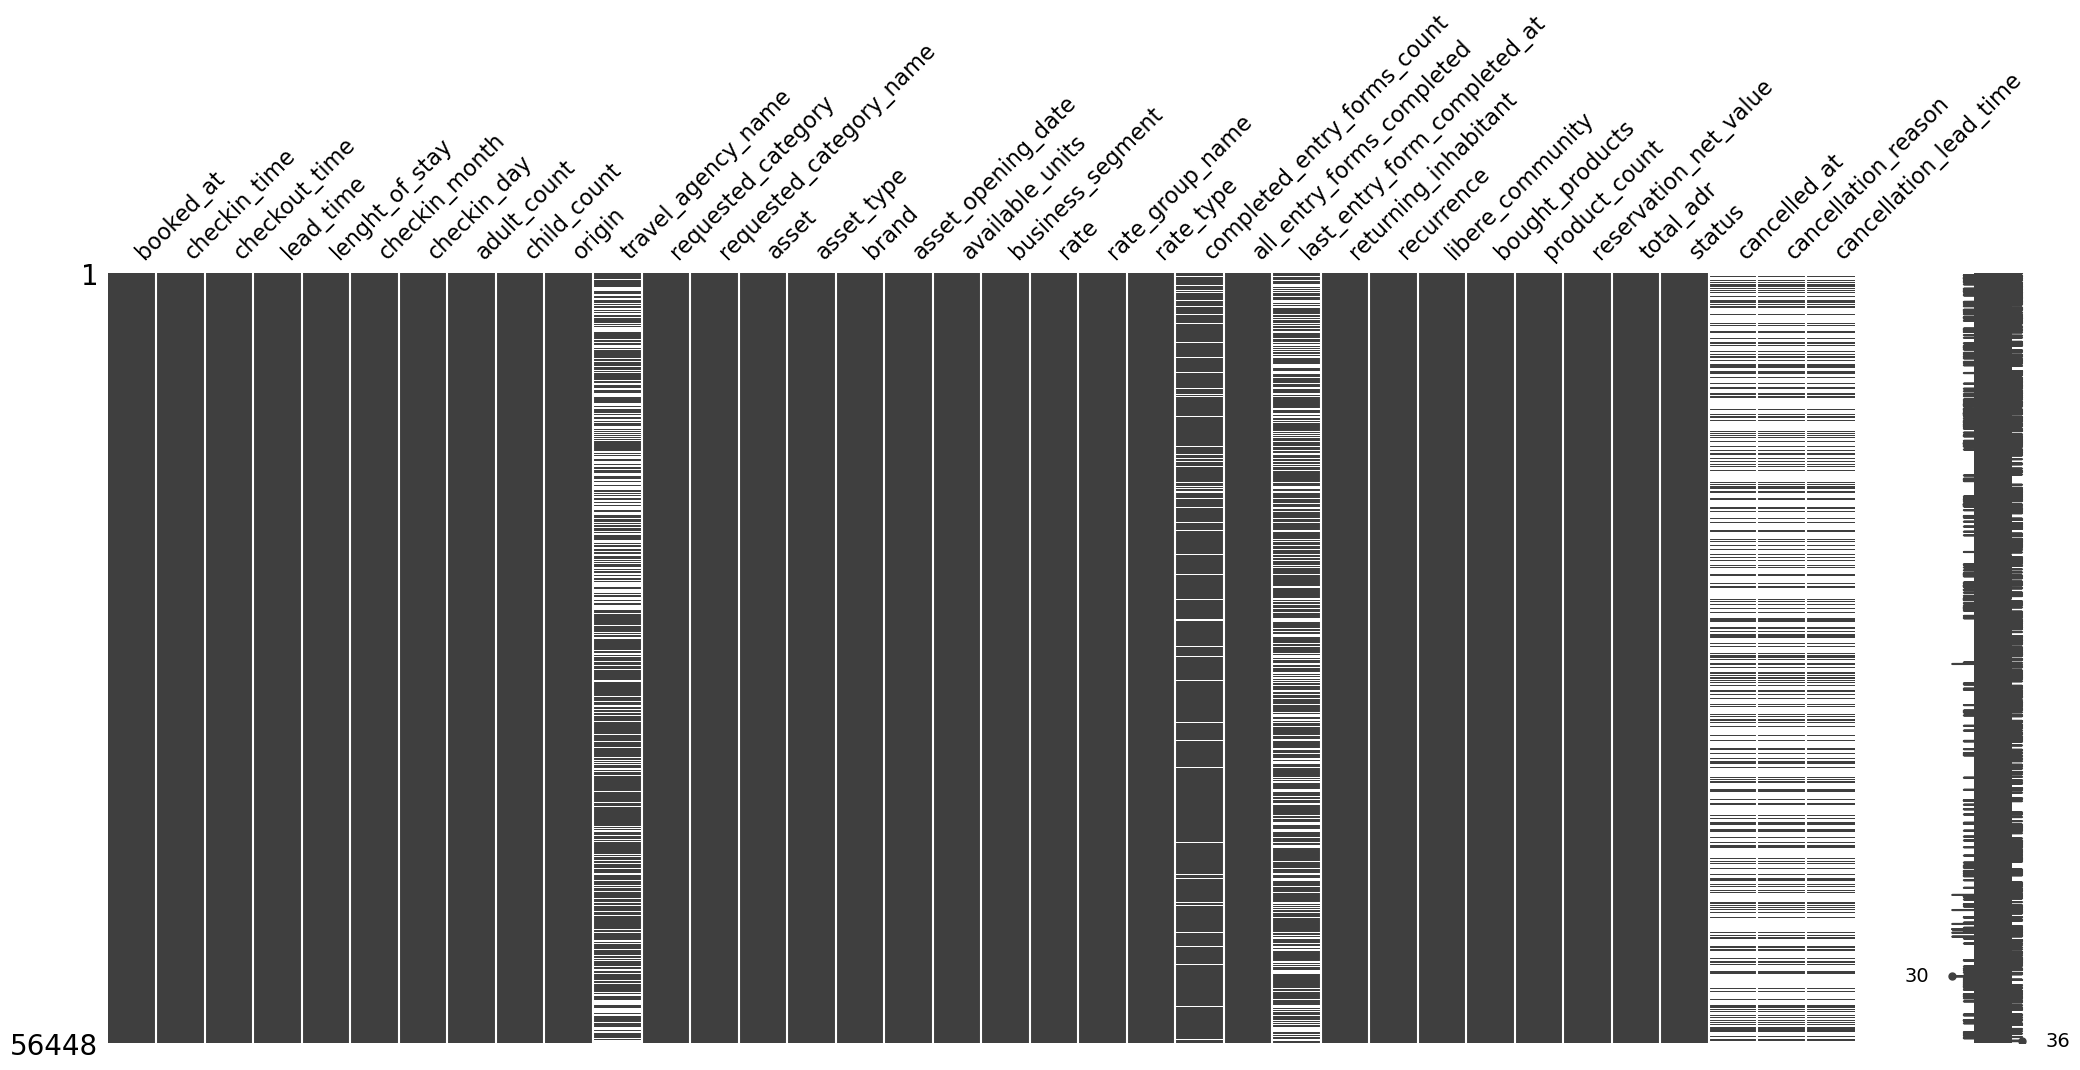

In [98]:
msno.matrix(df)

In [99]:
df["travel_agency_name"] = df["travel_agency_name"].fillna("Sin Agencia")

In [100]:
df["ciudad_destino"] = df["asset"].replace({"Koisi Hostel":"San Sebastián","Líbere Vitoria":"Vitoria",
                                            "Líbere Bilbao Museo":"Bilbao","Líbere Bilbao La Vieja":"Bilbao",
                                            "Líbere Valencia Abastos":"Valencia","Líbere Valencia Jardín Botánico":"Valencia",
                                            "Líbere Madrid Palacio Real":"Madrid","Líbere Málaga Teatro Romano":"Málaga",
                                            "Líbere Granada Catedral":"Granada","Líbere Málaga la Merced":"Málaga",
                                            "Líbere Córdoba Patio Santa Marta":"Córdoba","Líbere Pamplona Yamaguchi":"Pamplona"})

In [101]:
df["ciudad_destino"].value_counts()

ciudad_destino
Vitoria          13790
San Sebastián    11447
Córdoba          10293
Madrid            5114
Pamplona          3746
Málaga            3719
Valencia          3487
Bilbao            3286
Granada           1566
Name: count, dtype: int64

In [102]:
df = df.drop_duplicates()

In [103]:
df = df[(df['total_adr'] >= 0) | (df['reservation_net_value'] >= 0)]

In [ ]:
df = df[df['booked_at'] - df['checkin_day']]

AttributeError: Can only use .dt accessor with datetimelike values